In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

#Class Person、People
定義class Person=>一個人，class People=>一群人






In [38]:
class Person:
  def __init__(self):
    self.talent=0
    self.captial=10
    self.history=[10]
    self.pos=[]
    self.good=[]
    self.bad=[]
  def printHistory(self):
    x=len(self.history)
    plt.plot(range(x),self.history)
    plt.yscale("log")
    plt.show()
  def printEvents(self):
    plt.plot(self.good,color="red")
    plt.plot(self.bad,color="red")
    plt.show()

class People:
  def __init__(self,n,mapSize):
    self.person=self.generatePerson(n)
    self.position=self.generatePos(n,mapSize)
    self.captial=[]
  def generatePerson(self,n): #生成人物和智慧
    person=[]
    for i in range(n):
      person.append(Person())
    talent=np.random.normal(0.5, 0.1, n) #mean=0.5 std=0.15
    for i in range(n):
      if(talent[i]>=1):
        talent[i]=0.99
      elif(talent[i]<0):
        talent[i]=0
      person[i].talent=talent[i]
    return person

  def generatePos(self,n,mapSize): #生成人物位置，因為要不重複所以需要一次生成
    indices = np.random.choice(mapSize*mapSize, n, replace=False)
    x_indices, y_indices = np.unravel_index(indices, (mapSize,mapSize))
    pos= list(zip(x_indices, y_indices))
    for i in range(n):
      self.person[i].pos=pos[i]
  def CaptialDistribution(self,show=False):#畫出財富分布
    if(len(self.captial)==0):
      for x in self.person:
        self.captial.append(x.captial)
    if(show):
      captial=sorted(self.captial)
      TOP20=0
      Last80=0
      n=len(self.person)
      for i in range(int(0.8*n)):
        Last80+=captial[i]
      for j in range(int(0.8*n),n):
        TOP20+=captial[j]
      # print(TOP20)
      # print(Last80)
      print("Top 20:",f'{TOP20/(TOP20+Last80)*100:.2f}',"%")
      print("Remaining 80:",f'{Last80/(TOP20+Last80)*100:.2f}',"%")
      plt.hist(captial)
      plt.yscale("log")
      plt.show()
  def getRichesAndPoverty(self):#找出所有人中最有錢和最沒錢的人
    self.CaptialDistribution()
    richest=np.argmax(self.captial)
    poorest=np.argmin(self.captial)

    return self.person[richest],self.person[poorest]

  def printTalent(self): #畫出所有人的talent分布
    talent=[]
    for x in self.person:
      talent.append(x.talent)
    plt.title("Talent Distribution")
    plt.hist(talent)
    plt.show()

#Class event_map
定義class event_map 描述好事、壞事的分布位置和移動方式

In [39]:
class event_map:
  def __init__(self,mapSize,event_num):
    self.map=np.zeros((mapSize,mapSize),dtype=np.int32)
    self.mapSize=mapSize
    self.coord=self.position(event_num)
    self.Events=np.zeros((mapSize,mapSize),dtype=np.int32)
    self.direct=self.genDirect(21)
  def genDirect(self,n): #生成從中心移動到21x21個位置所需要的位移量，方便計算移動後的事件座標
    matrix = np.arange(1, n * n + 1).reshape(n, n)

    center_row, center_col = n//2, n//2
    moves = {}
    for row in range(n):
        for col in range(n):
            row_diff = row - center_row
            col_diff = col - center_col
            moves[matrix[row, col]] = [row_diff, col_diff]
    return moves
  def position(self,event_num): #生成事件的位置
    indices = np.random.choice(self.mapSize*self.mapSize, event_num, replace=False)
    points = np.unravel_index(indices, (self.mapSize,self.mapSize))
    x_indices, y_indices = points
    self.map[x_indices, y_indices] = 1
    return list(list(a) for a in zip(x_indices,y_indices))
  def checkBoundary(self,r,row): #確認移動後的座標是否超過世界邊界，如果是就需要調整
    if(r<0):
      s=-r
      return row-s ##跨過左/上邊界，跳回右/下邊
    elif(r>row-1):
      s=r-row+1
      return s-1 ##超過右/下邊界，跳回左/上邊
    else:
      return r
  def move(self): #事件移動
    for event_id in range(len(self.coord)):
      dice=np.random.choice(range(1,442))
      self.map[self.coord[event_id][0]][self.coord[event_id][1]]-=1 #原本位置的好事數量減1
      self.coord[event_id][0]=self.checkBoundary(self.coord[event_id][0]+self.direct[dice][0],self.mapSize) #移動後的row值
      self.coord[event_id][1]=self.checkBoundary(self.coord[event_id][1]+self.direct[dice][1],self.mapSize) #移動後的col值
      self.map[self.coord[event_id][0]][self.coord[event_id][1]]+=1 #移動後的位置的好事加1
  def printmap(self): #畫出目前事件在地圖上的分布
    print(self.coord)
    print(self.map)
  def conv(self,kernelsize): #計算人物周圍九宮格內的事件數量
    kernel=np.ones((kernelsize,kernelsize),dtype=np.int32)
    padded_map = np.pad(self.map, ((1, 1), (1, 1)), mode='constant', constant_values=0)
    self.Events=convolve2d(padded_map, kernel, mode='valid')




In [40]:
def chance(people,eventmap,mode): #計算每半年每個人經歷好事和壞事後的財富
  if(mode=="G"):  #好事
    for person in people:
      x=person.pos[0]
      y=person.pos[1]
      num=eventmap.Events[x][y]
      person.good.append(num)
      while(num):
        x=np.random.rand()
        if(person.talent>=x):
          continue
        else:
          person.captial*=2
        num-=1

  else:      #壞事
    for person in people:
      x=person.pos[0]
      y=person.pos[1]
      num=eventmap.Events[x][y]
      person.bad.append(-num)
      while(num):
        person.captial*=0.5

        num-=1






In [41]:
def snapshot(person,good,bad): #畫出目前世件的分布
  personLocx=[]
  personLocy=[]
  for x in person:
    personLocx.append(x.pos[0])
    personLocy.append(x.pos[1])

  goodLocx=[]
  goodLocy=[]
  print(len(good.coord))
  for x in good.coord:
    goodLocx.append(x[0])
    goodLocy.append(x[1])

  badLocx=[]
  badLocy=[]
  print(len(bad.coord))
  for x in bad.coord:
    badLocx.append(x[0])
    badLocy.append(x[1])

  plt.figure(figsize=(10,10))
  # plt.scatter(personLocx,personLocy,color="black",marker='*')
  plt.scatter(goodLocx,goodLocy,color="red")
  plt.scatter(badLocx,badLocy,color="green")
  plt.show()

#實際模擬
模擬10000人，世界地圖大小為500x500，並統計40年，每半年記錄一次財富，並print出財富的分布，和最有錢跟最沒錢的人的財富。

In [42]:
n=10000 #人數
event_num=n//16 #好事壞事的事件數
mapSize=500 #世界的大小500x500
year=40 #統計40年
k=year*2 #每半年統計一次財富

residents=People(n,mapSize)
good=event_map(mapSize,event_num)
bad=event_map(mapSize,event_num)
while(k):
  good.move()
  good.conv(3)
  chance(residents.person,good,mode="G")
  bad.move()
  bad.conv(3)
  chance(residents.person,bad,mode="B")
  for x in residents.person:
    x.history.append(x.captial)
  k-=1


625
625


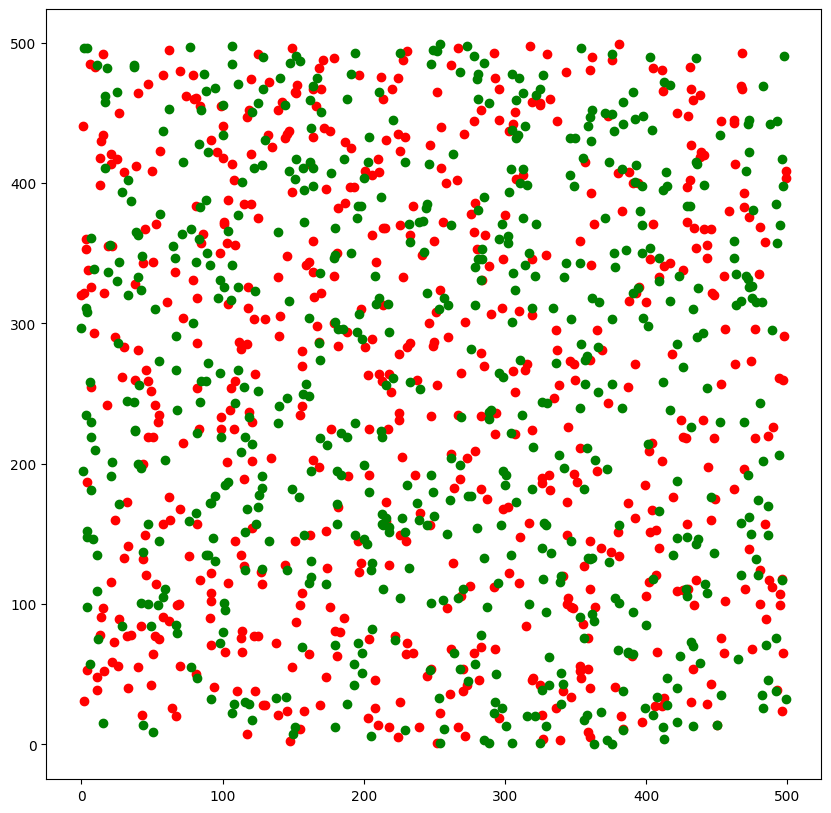

In [43]:
snapshot(residents.person,good,bad)

Top 20: 77.17 %
Remaining 80: 22.83 %


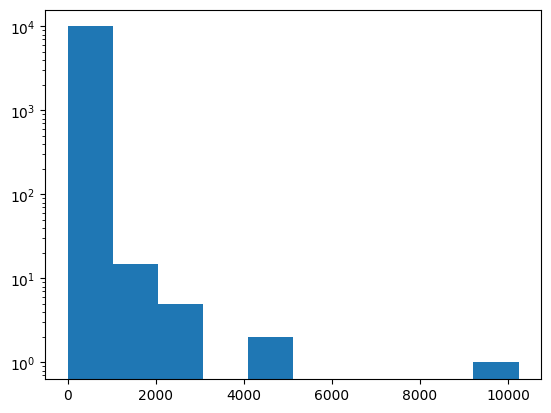

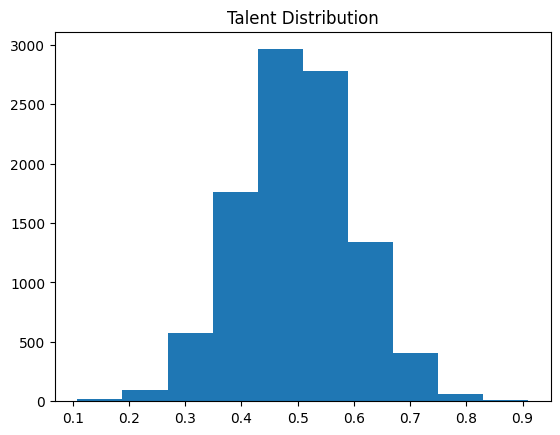

In [44]:
#印出前20%的人所擁有的財富占比
#和剩下80%的人的財富占比
residents.CaptialDistribution(show=True)
residents.printTalent()

Richest 0.3685511933929822
10240.0


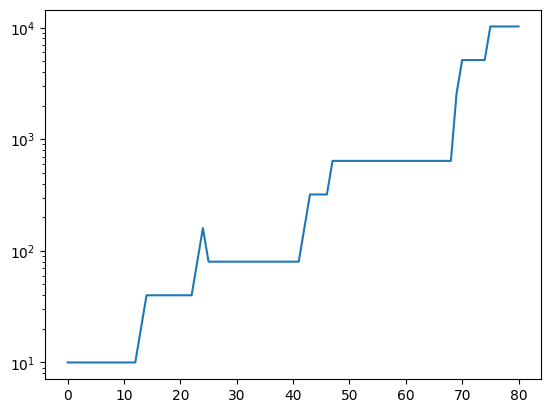

Poorest 0.4911893465910035
0.01953125


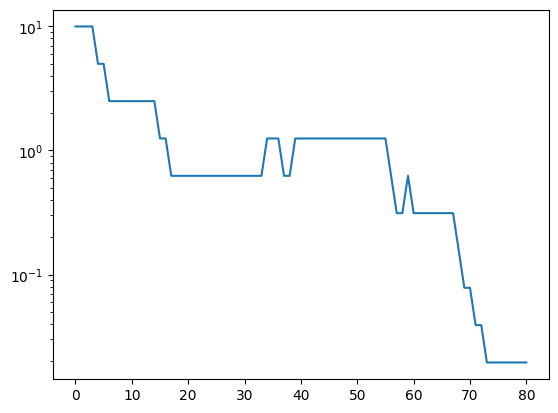

In [45]:
richest,poorest=residents.getRichesAndPoverty()
print("Richest",richest.talent)
print(richest.captial)
richest.printHistory()

print("Poorest",poorest.talent)
print(poorest.captial)
poorest.printHistory()

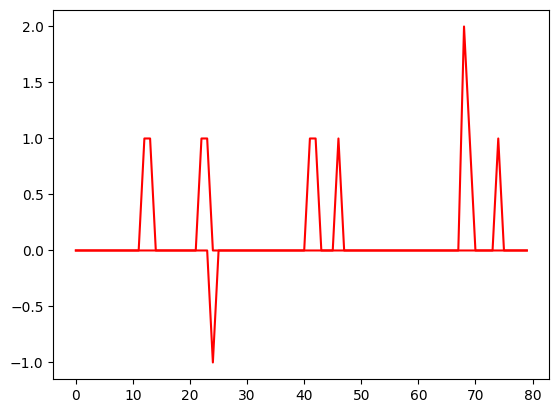

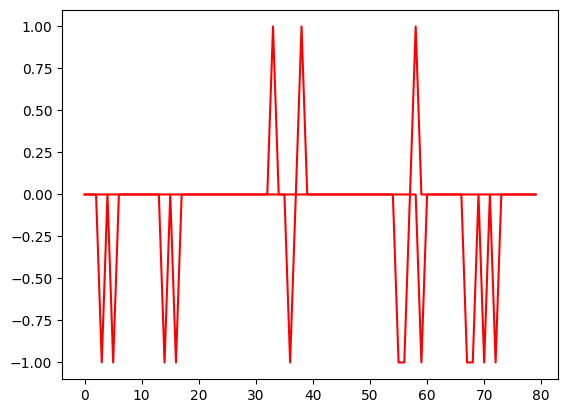

In [46]:
richest.printEvents()
poorest.printEvents()


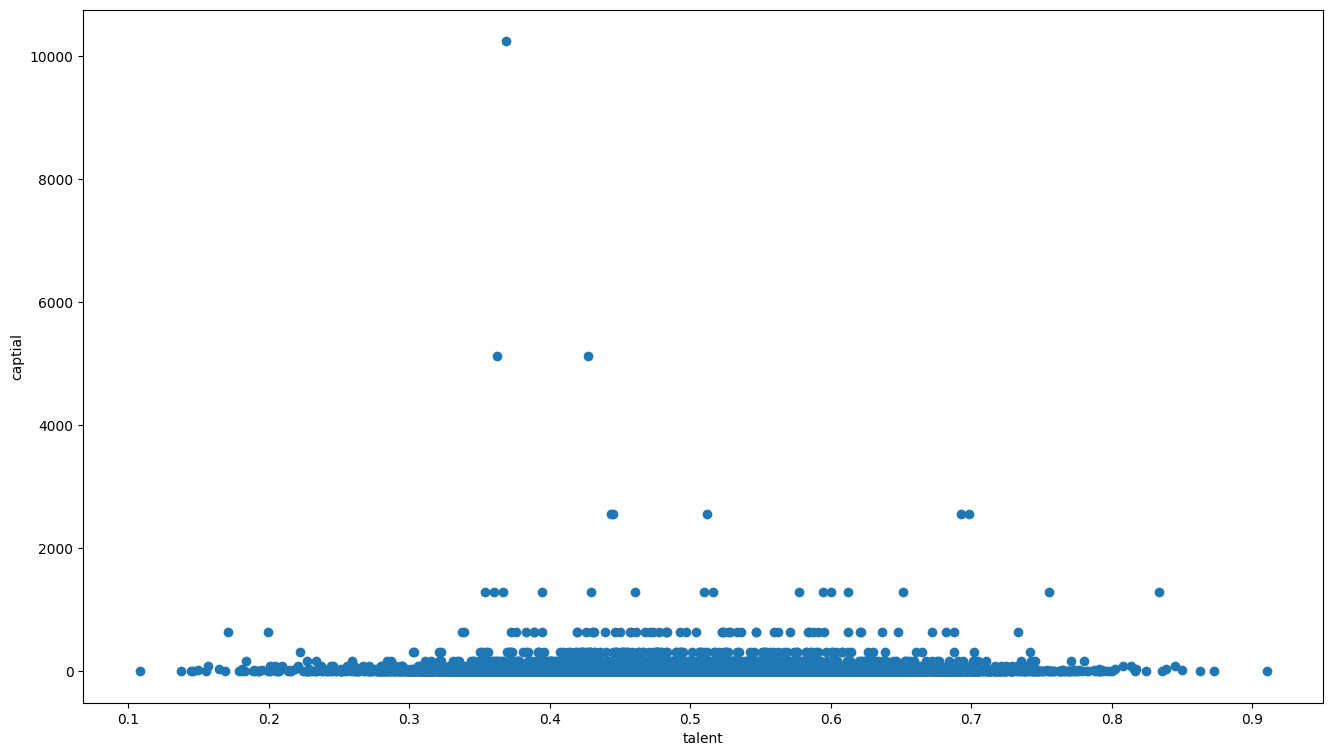

In [47]:
talent=[]
captial=[]
luckyEvents=[]
badEvents=[]
for person in residents.person:
  talent.append(person.talent)
  captial.append(person.captial)
  luckyEvents.append(sum(person.good))
  badEvents.append(-sum(person.bad))

plt.figure(figsize=(16,9))
plt.scatter(talent,captial)
plt.xlabel("talent")
plt.ylabel("captial")
plt.show()


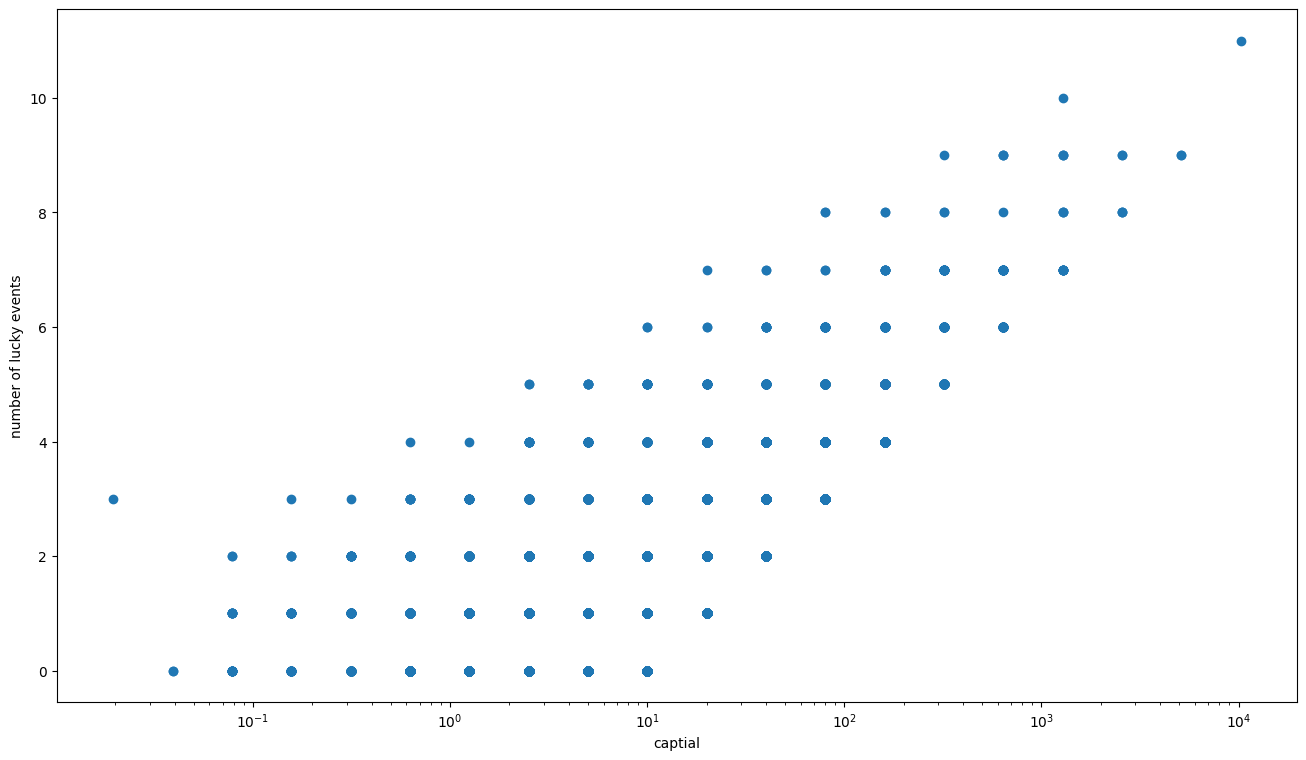

In [48]:
plt.figure(figsize=(16,9))
plt.scatter(captial,luckyEvents)
plt.xlabel("captial")
plt.ylabel("number of lucky events")
plt.xscale("log")
plt.show()

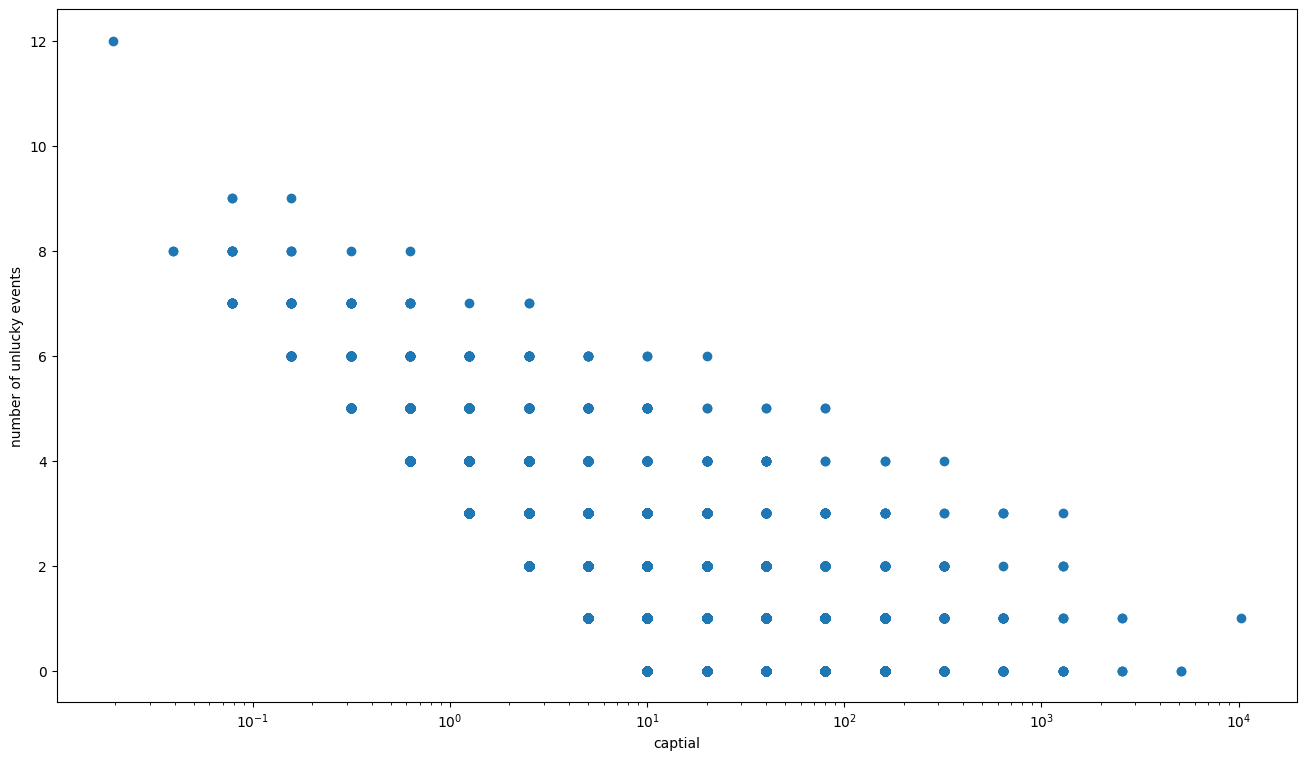

In [49]:
plt.figure(figsize=(16,9))
plt.scatter(captial,badEvents)
plt.xlabel("captial")
plt.ylabel("number of unlucky events")
plt.xscale("log")
plt.show()

# 多次模擬

In [50]:
import multiprocessing as mp
import os

In [63]:
n=10000 #人數
event_num=n//16 #好事壞事的事件數
mapSize=500 #世界的大小500x500
year=40 #統計40年

ans=[]
for i in range(100):
  k=year*2 #每半年統計一次財富
  residents=People(n,mapSize)
  good=event_map(mapSize,event_num)
  bad=event_map(mapSize,event_num)
  while(k):
    good.move()
    good.conv(3)
    chance(residents.person,good,mode="G")
    bad.move()
    bad.conv(3)
    chance(residents.person,bad,mode="B")
    for x in residents.person:
      x.history.append(x.captial)
    k-=1
  rich,poor=residents.getRichesAndPoverty()
  ans.append([rich.talent,poor.talent])

In [64]:
print(ans)

[[0.5493141421610171, 0.5124093487168498], [0.4288941011410133, 0.393974863168279], [0.4070711874457936, 0.44566030700164894], [0.644505804660364, 0.4884910513370505], [0.5196377649714934, 0.6372686353863601], [0.6166606393516598, 0.5974290973296524], [0.6500369718936123, 0.18496225518957837], [0.30511011323144865, 0.46927907145962294], [0.39094021692687564, 0.503348702125123], [0.5938568616256982, 0.4307595964252628], [0.44056633031546516, 0.6658561814069606], [0.44856185880181565, 0.48604071204148463], [0.25872233706470527, 0.4841231840580033], [0.5987321504904266, 0.4819433269588181], [0.4966020337411776, 0.5964599808163313], [0.46632698308880693, 0.7571229311807799], [0.5446087679722215, 0.449801111671245], [0.5828638077455682, 0.38954955755875703], [0.4873629455726531, 0.37684026906042084], [0.5784222088627552, 0.5443152971491994], [0.5593657494057046, 0.49667281730212126], [0.50659535594709, 0.5199747027180867], [0.4880300265865133, 0.5838735913368098], [0.4713227362583704, 0.409

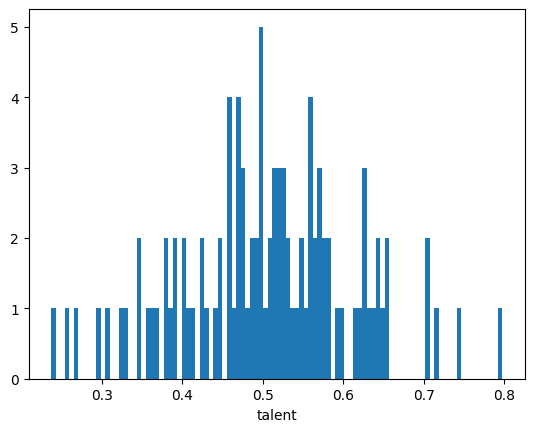

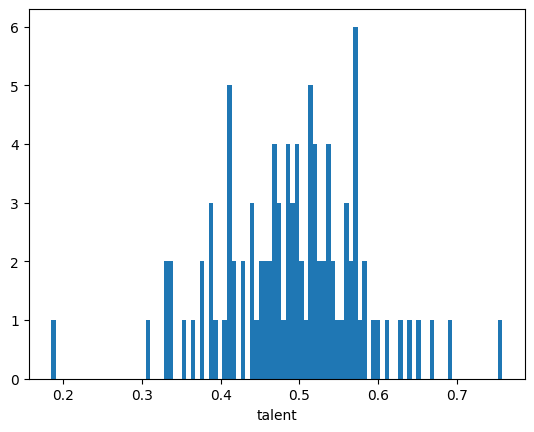

In [66]:
top=[]
last=[]
for test in ans:
  top.append(test[0])
  last.append(test[1])

plt.hist(top,bins=100)
plt.xlabel("talent")
plt.show()

plt.hist(last,bins=100)
plt.xlabel("talent")
plt.show()